In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor,early_stopping
from sklearn.metrics import mean_squared_error



# intra-subject (被験者内)評価

In [40]:
df = pd.read_csv("../../data/results/ppg_features_pulsedb_test_min180.csv", index_col=0) 
df.columns

Index(['Tc', 'Ts', 'Td', 'Tsteepest', 'Steepest', 'TNegSteepest',
       'NegSteepest', 'TdiaRise', 'DiaRise', 'SteepDiaRise',
       ...
       'T_peak_e_norm', 'AI', 'bd', 'bcda', 'sdoo', 'cycle_zero',
       'signal_index', 'sbp', 'dbp', 'subject'],
      dtype='object', length=102)

In [ ]:
   
# グループごとの結果を保存
from sklearn.metrics import mean_absolute_error


results = []

for group_id, group_df in df.groupby("subject"):
    # print(f"=== Group {group_id} ===")
    
           'NegSteepest', 'TdiaRise', 'DiaRise', 'SteepDiaRise',
           ...
           'T_peak_e_norm', 'AI', 'bd', 'bcda', 'sdoo', 'cycle_zero',
           'signal_index', 'sbp', 'dbp', 'subject'],
          dtype='object', length=102)
    # 特徴量と目的変数
    X = group_df.drop(columns=["sbp", "subject","dbp","signal_index"])
    y = group_df["sbp"]

    # train/test 分割（行単位）
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    # 標準化
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()
    # LightGBM Regressor
    model = LGBMRegressor(random_state=42,min_child_samples=5,min_split_gain=0.1,verbose=-1)
    model.fit(X_train_scaled, y_train_scaled)

    # 予測と評価
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)   
    me = (y_test - y_pred).mean()
    std = (y_test - y_pred).std()

    results.append({
        "subject": group_id,
        # "model": model,
        "mse": mse,
        "mae": mae,
        "me": me,
        "std": std
    })
    print(f"== Group {group_id} == MSE: {mse:.4f}, MAE: {mae:.4f}, ME: {me:.4f}, STD: {std:.4f}")
df_results = pd.DataFrame(results)
df_results.to_csv("../../data/results/ppg_lgbm_sbp_test.csv", index=False)
# 全グループの評価結果
print("==== Summary ====")
for res in results:
    print(f"Group {res['subject']}: MSE={res['mse']:.4f}, MAE={res['mae']:.4f}, ME={res['me']:.4f}, STD={res['std']:.4f}")


== Group 53 == MSE: 103.0759, MAE: 7.9176, ME: 1.3895, STD: 10.1319
== Group 68 == MSE: 39.7900, MAE: 2.5132, ME: 0.8669, STD: 6.2875
== Group 103 == MSE: 4.1580, MAE: 1.4981, ME: -0.1423, STD: 2.0471
== Group 184 == MSE: 10.4171, MAE: 2.4139, ME: -0.5007, STD: 3.2141
== Group 195 == MSE: 24.4850, MAE: 3.5474, ME: 0.4629, STD: 4.9588
== Group 205 == MSE: 47.7248, MAE: 4.5932, ME: 0.9527, STD: 6.8903
== Group 216 == MSE: 185.7481, MAE: 8.2686, ME: -2.9812, STD: 13.4312
== Group 266 == MSE: 22.2909, MAE: 3.4691, ME: 0.1069, STD: 4.7818
== Group 303 == MSE: 30.8469, MAE: 3.9014, ME: -0.6188, STD: 5.5547
== Group 317 == MSE: 54.8295, MAE: 5.1299, ME: -0.6618, STD: 7.4667
== Group 328 == MSE: 26.0466, MAE: 3.1016, ME: -0.6347, STD: 5.1176
== Group 340 == MSE: 7.5974, MAE: 2.0476, ME: -0.1562, STD: 2.7707
== Group 558 == MSE: 12.4799, MAE: 2.1559, ME: 0.1607, STD: 3.5542
== Group 630 == MSE: 127.2045, MAE: 8.1573, ME: 1.4928, STD: 11.2636
== Group 665 == MSE: 21.5909, MAE: 2.6174, ME: -1.100

(array([ 1.,  3., 14., 26., 33., 39., 28., 30., 22., 17., 14., 11.,  2.,
         7.,  2.,  0.,  2.,  0.,  0.,  1.]),
 array([ 0.67212735,  1.23132208,  1.79051682,  2.34971156,  2.90890629,
         3.46810103,  4.02729577,  4.58649051,  5.14568524,  5.70487998,
         6.26407472,  6.82326945,  7.38246419,  7.94165893,  8.50085367,
         9.0600484 ,  9.61924314, 10.17843788, 10.73763261, 11.29682735,
        11.85602209]),
 <BarContainer object of 20 artists>)

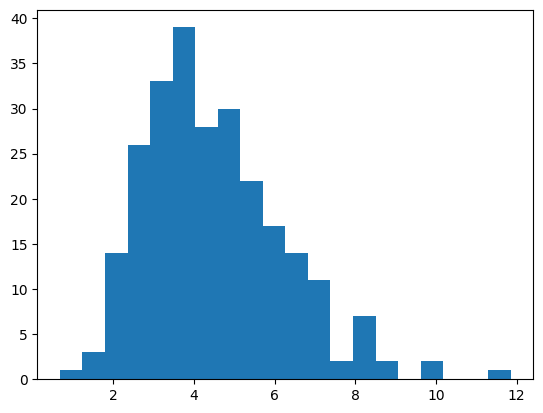

In [42]:
import matplotlib.pyplot as plt
plt.hist(df_results["mae"], bins=20)

(array([ 1.,  3., 14., 26., 33., 39., 28., 30., 22., 17., 14., 11.,  2.,
         7.,  2.,  0.,  2.,  0.,  0.,  1.]),
 array([ 0.67212735,  1.23132208,  1.79051682,  2.34971156,  2.90890629,
         3.46810103,  4.02729577,  4.58649051,  5.14568524,  5.70487998,
         6.26407472,  6.82326945,  7.38246419,  7.94165893,  8.50085367,
         9.0600484 ,  9.61924314, 10.17843788, 10.73763261, 11.29682735,
        11.85602209]),
 <BarContainer object of 20 artists>)

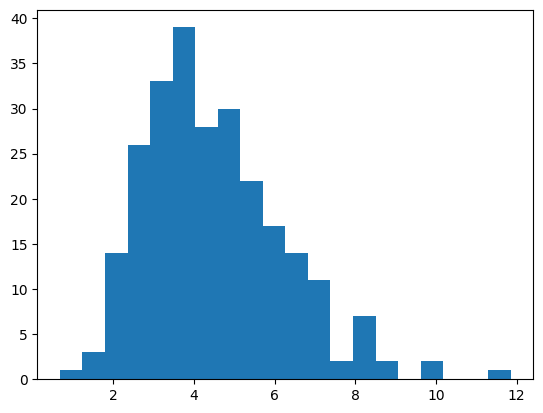

In [43]:
plt.hist(df_results["mae"], bins=20)

In [ ]:
sbp 

In [45]:
results = []
for group_id, group_df in df.groupby("subject"):
    sbp = group_df["sbp"].values
    sbp_mean = sbp.mean()
    sbp_std = sbp.std()
    results.append({"subject": group_id, "sbp_mean": sbp_mean, "sbp_std": sbp_std})
df_sbp_stats = pd.DataFrame(results)
df_sbp_stats.to_csv("../../data/results/ppg_sbp_stats_test.csv", index=False)

Text(0.5, 0, 'Regressor MAE')

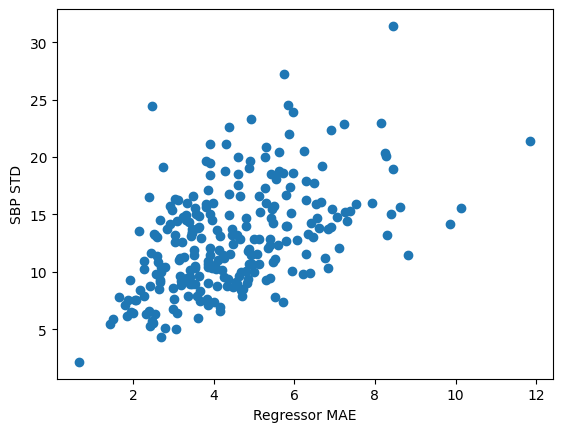

In [46]:
plt.scatter(df_results["mae"], df_sbp_stats["sbp_std"])
plt.ylabel("SBP STD") 
plt.xlabel("Regressor MAE")

Text(0.5, 0, 'Regressor MAE')

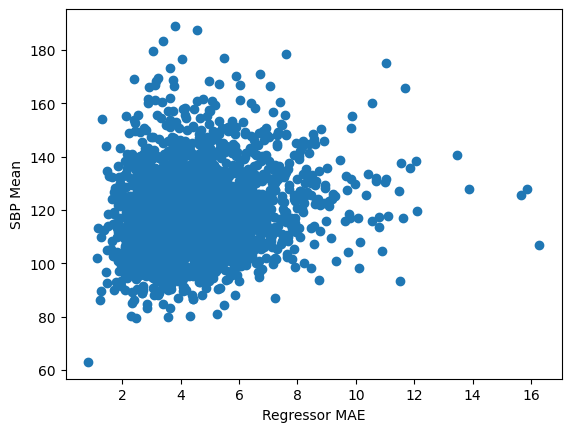

In [17]:
plt.scatter(df_results["mae"], df_sbp_stats["sbp_mean"])
plt.ylabel("SBP Mean") 
plt.xlabel("Regressor MAE")

In [21]:
a = pd.read_csv("../../data/results/ppg_features_pulsedb_train_min180.csv")

In [22]:
a.shape

(701639, 103)

# leave one subject out

時間かかりすぎ
テストデータを被験者毎に出した方がいい

In [4]:
   
# グループごとの結果を保存
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

results = []

# leave-one-subject-out CV
for group_id, group_df in tqdm(df.groupby("subject")):
    # 特徴量と目的変数
    X_train = df[df["subject"] != group_id].drop(columns=["sbp", "subject","dbp","signal_index"])
    y_train = df[df["subject"] != group_id]["sbp"]
    X_test = group_df.drop(columns=["sbp", "subject","dbp","signal_index"])
    y_test = group_df["sbp"]
    # 標準化
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()
    # LightGBM Regressor
    model = LGBMRegressor(random_state=42,min_child_samples=5,min_split_gain=0.1,verbose=-1)
    model.fit(X_train_scaled, y_train_scaled)

    # 予測と評価
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)   
    me = (y_test - y_pred).mean()
    std = (y_test - y_pred).std()

    results.append({
        "subject": group_id,
        # "model": model,
        "mse": mse,
        "mae": mae,
        "me": me,
        "std": std
    })
    print(f"== Group {group_id} == MSE: {mse:.4f}, MAE: {mae:.4f}, ME: {me:.4f}, STD: {std:.4f}")
df_results = pd.DataFrame(results)
df_results.to_csv("../../data/results/ppg_lgbm_loso_sbp.csv", index=False)
# 全グループの評価結果
print("==== Summary ====")
for res in results:
    print(f"Group {res['subject']}: MSE={res['mse']:.4f}, MAE={res['mae']:.4f}, ME={res['me']:.4f}, STD={res['std']:.4f}")


  0%|          | 1/2225 [00:05<3:14:07,  5.24s/it]

== Group 1 == MSE: 252.2020, MAE: 12.6200, ME: 12.2013, STD: 10.1793


  0%|          | 2/2225 [00:10<3:09:29,  5.11s/it]

== Group 3 == MSE: 243.8056, MAE: 12.5075, ME: -12.0879, STD: 9.8982


  0%|          | 3/2225 [00:15<3:09:42,  5.12s/it]

== Group 5 == MSE: 175.0554, MAE: 9.7634, ME: 8.8677, STD: 9.8354


  0%|          | 4/2225 [00:20<3:10:14,  5.14s/it]

== Group 12 == MSE: 78.8396, MAE: 7.4716, ME: -1.0767, STD: 8.8261


  0%|          | 4/2225 [00:21<3:14:38,  5.26s/it]


KeyboardInterrupt: 

# train 

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split,GroupKFold
from sklearn.preprocessing import StandardScaler

In [15]:
# train/validation with train, test with test
# cv with patient-wise split
train_df = pd.read_csv("../../data/results/ppg_features_pulsedb_train_min180.csv", index_col=0) 
test_df = pd.read_csv("../../data/results/ppg_features_pulsedb_test_min180.csv", index_col=0) 

X_train = train_df.drop(columns=["sbp", "subject","dbp","signal_index"])
y_train = train_df["sbp"]
gkf = GroupKFold(n_splits=5)
models = []
scalers = []
for fold, (train_idx, val_idx) in enumerate(gkf.split(X_train, y_train, groups=train_df["subject"])):
    print(f"=== Fold {fold} ===")
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    mean_y = y_tr.mean()
    std_y = y_tr.std()
    median_y = y_tr.median()
    print(f"Train SBP mean: {mean_y:.2f}, std: {std_y:.2f}, median: {median_y:.2f}")
    # 標準化
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_val_scaled = scaler.transform(X_val)
    scaler_y = StandardScaler()
    y_tr_scaled = scaler_y.fit_transform(y_tr.values.reshape(-1, 1)).ravel()
    y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).ravel()
    callbacks = [early_stopping(stopping_rounds=50)]
    # LightGBM Regressor
    model = LGBMRegressor(random_state=42,min_child_samples=5,n_estimators=1000,min_split_gain=0.1,verbose=-1)
    model.fit(X_tr_scaled, y_tr_scaled,eval_set=[(X_val_scaled, y_val_scaled)],callbacks=callbacks)
    scalers.append((scaler, scaler_y))
    # 予測と評価
    y_val_pred_scaled = model.predict(X_val_scaled)
    y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).ravel()
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)   
    print(f"Validation MSE: {val_mse:.4f}, MAE: {val_mae:.4f}")
    models.append(model)
# テストデータで評価
# get metrics from each patient
results = []
for j, model in enumerate(models):
    print(f"=== Test with Model {j} ===")
    scaler, scaler_y = scalers[j]
    result_metrics = []
    for i, (group_id, group_df) in enumerate(test_df.groupby("subject")):
        X_test = group_df.drop(columns=["sbp", "subject","dbp","signal_index"])
        y_test = group_df["sbp"]
        X_test_scaled = scaler.transform(X_test)
        y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()
        y_test_pred_scaled = model.predict(X_test_scaled)
        y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).ravel()
        mse = mean_squared_error(y_test, y_test_pred)
        mae = mean_absolute_error(y_test, y_test_pred)   
        me = (y_test - y_test_pred).mean()
        std = (y_test - y_test_pred).std()

        result_metrics.append({
            "subject": group_id,
            # "model": model,
            "mse": mse,
            "mae": mae,
            "me": me,
            "std": std
        })
        print(f"Subject {group_id} Test MSE: {mse:.4f}, MAE: {mae:.4f}")
    results.append(result_metrics)
    pd.DataFrame(result_metrics).to_csv(f"../../data/results/ppg_lgbm_sbp_test_fold{j}.csv", index=False)


=== Fold 0 ===
Train SBP mean: 119.13, std: 20.75, median: 117.21
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[98]	valid_0's l2: 0.870848
Validation MSE: 374.8177, MAE: 15.3136
=== Fold 1 ===
Train SBP mean: 119.26, std: 20.89, median: 117.34
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[172]	valid_0's l2: 0.797813
Validation MSE: 348.0131, MAE: 14.6392
=== Fold 2 ===
Train SBP mean: 119.31, std: 20.96, median: 117.30
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[202]	valid_0's l2: 0.802209
Validation MSE: 352.3469, MAE: 14.4499
=== Fold 3 ===
Train SBP mean: 119.30, std: 20.97, median: 117.47
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[181]	valid_0's l2: 0.759113
Validation MSE: 333.7999, MAE: 14.2233
=== Fold 4 ===
Train SBP mean: 119.06, std: 20.92, median: 117.05
Training until 

In [50]:
results = []
for j, model in enumerate(models):
    print(f"=== Test with Model {j} ===")
    scaler, scaler_y = scalers[j]
    result_metrics = []
    for i, (group_id, group_df) in enumerate(test_df.groupby("subject")):
        X_test = group_df.drop(columns=["sbp", "subject","dbp","signal_index"])
        y_test = group_df["sbp"]
        X_test_scaled = scaler.transform(X_test)
        y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()
        y_test_pred_scaled = model.predict(X_test_scaled)
        y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).ravel()
        mse = mean_squared_error(y_test, y_test_pred)
        mae = mean_absolute_error(y_test, y_test_pred)   
        me = (y_test - y_test_pred).mean()
        std = (y_test - y_test_pred).std()

        result_metrics.append({
            "subject": group_id,
            # "model": model,
            "mse": mse,
            "mae": mae,
            "me": me,
            "std": std,
            "bp_mean": group_df["sbp"].mean(),
            "bp_std": group_df["sbp"].std()
        })
        print(f"Subject {group_id} Test MSE: {mse:.2f}, MAE: {mae:.2f}, STD: {std:.2f} BP Mean: {group_df['sbp'].mean():.1f}, BP STD: {group_df['sbp'].std():.2f}")
    results.append(result_metrics)
    pd.DataFrame(result_metrics).to_csv(f"../../data/results/ppg_lgbm_sbp_test_fold{j}.csv", index=False)


=== Test with Model 0 ===
Subject 53 Test MSE: 249.77, MAE: 11.65, STD: 14.43 BP Mean: 130.4, BP STD: 16.03
Subject 68 Test MSE: 194.20, MAE: 8.64, STD: 11.30 BP Mean: 120.3, BP STD: 13.34
Subject 103 Test MSE: 213.26, MAE: 13.91, STD: 4.44 BP Mean: 132.1, BP STD: 5.90
Subject 184 Test MSE: 360.33, MAE: 18.19, STD: 7.43 BP Mean: 101.4, BP STD: 5.25
Subject 195 Test MSE: 541.98, MAE: 20.96, STD: 10.24 BP Mean: 136.8, BP STD: 15.60
Subject 205 Test MSE: 513.30, MAE: 20.07, STD: 15.81 BP Mean: 123.3, BP STD: 20.06
Subject 216 Test MSE: 282.78, MAE: 12.59, STD: 15.28 BP Mean: 125.3, BP STD: 20.11
Subject 266 Test MSE: 177.85, MAE: 9.47, STD: 11.68 BP Mean: 109.5, BP STD: 13.52
Subject 303 Test MSE: 229.43, MAE: 12.42, STD: 10.25 BP Mean: 123.8, BP STD: 18.42
Subject 317 Test MSE: 406.93, MAE: 16.74, STD: 11.88 BP Mean: 100.4, BP STD: 12.92
Subject 328 Test MSE: 168.71, MAE: 11.01, STD: 12.80 BP Mean: 104.5, BP STD: 14.42
Subject 340 Test MSE: 50.36, MAE: 5.90, STD: 5.92 BP Mean: 113.6, BP 

In [51]:
df_results = pd.DataFrame(results[0])

In [18]:
import matplotlib.pyplot as plt


Text(0.5, 0, 'Regressor MAE')

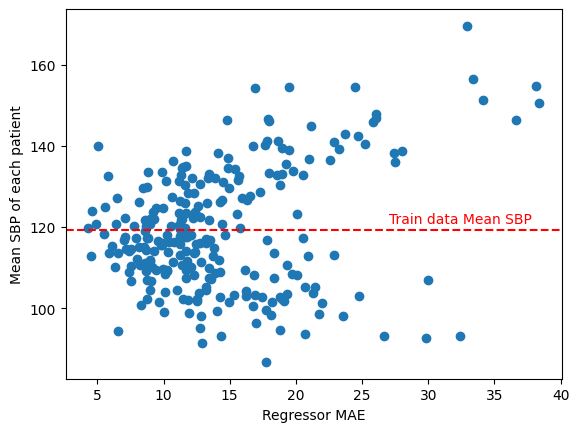

In [38]:
plt.axhline(y=119.3, color='r', linestyle='--'  )
plt.text(27, 121, 'Train data Mean SBP', color='r')
plt.scatter(df_results["mae"], df_results["bp_mean"])
plt.ylabel("Mean SBP of each patient") 
plt.xlabel("Regressor MAE")

Text(0.5, 0, 'Regressor MAE')

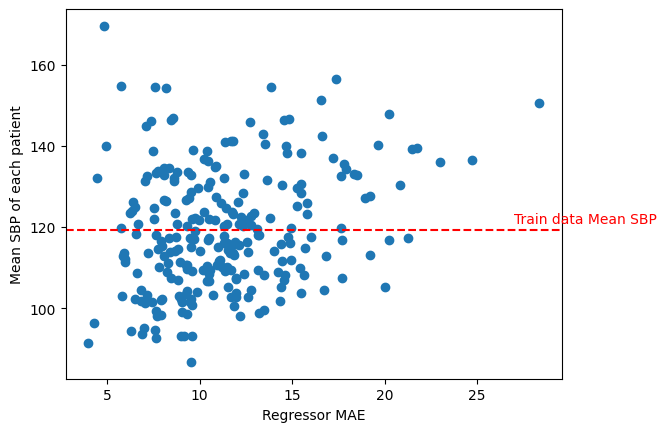

In [52]:
plt.axhline(y=119.3, color='r', linestyle='--'  )
plt.text(27, 121, 'Train data Mean SBP', color='r')
plt.scatter(df_results["std"], df_results["bp_mean"])
plt.ylabel("Mean SBP of each patient") 
plt.xlabel("Regressor MAE")

In [68]:
import numpy as np

19
12
20
28
29
12


(80.0, 183.0)

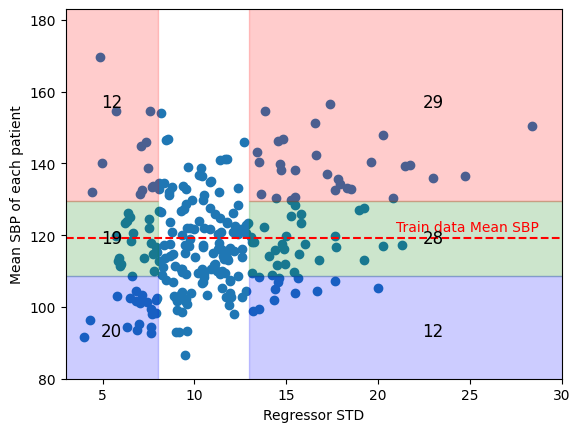

In [89]:
plt.axhline(y=119.3, color='r', linestyle='--'  )
plt.text(21, 121, 'Train data Mean SBP', color='r')
plt.scatter(df_results["std"], df_results["bp_mean"])
plt.ylabel("Mean SBP of each patient") 
plt.xlabel("Regressor STD")
# create transparent square region
m_ = 119.13
s_ =20.75
# green left, red left, blue left, green right, red right, blue right
limit = [[0,0,0,13,13,13],
         [m_-s_*0.5,m_+s_*0.5,m_-s_*2,m_-s_*0.5,m_+s_*0.5,m_-s_*2],
         [8,8, 8,30,30,30],
         [s_,55,s_*1.5,s_,55,s_*1.5]]
color = ['green','red','blue','green','red','blue']
for i in range(6):
    plt.gca().add_patch(plt.Rectangle((limit[0][i],limit[1][i]),  limit[2][i],limit[3][i], color=color[i], alpha=0.2))
    count = np.sum((df_results["bp_mean"] >= limit[1][i]) & (df_results["bp_mean"] < limit[1][i]+limit[3][i]) &
                   (df_results["std"] >= limit[0][i]) & (df_results["std"] < limit[0][i]+limit[2][i]))
    plt.text(3+(limit[0][i]+limit[2][i]-3)/2, (limit[1][i])+limit[3][i]/2, str(count), color='black', fontsize=12, ha='center', va='center')
    print(count)
plt.xlim(3, 30)
plt.ylim(80,183)


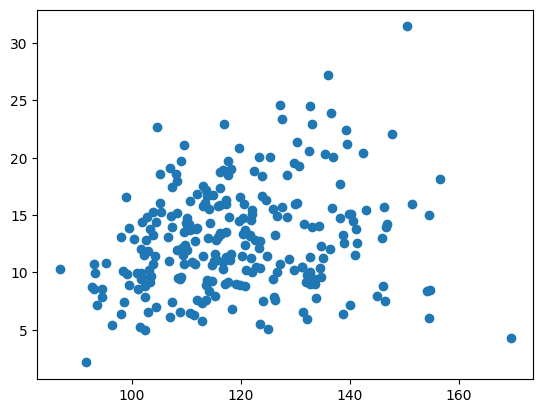

In [39]:
plt.scatter(df_results["bp_mean"], df_results["bp_std"])

## 平均血圧、　低血圧、　高血圧で　低精度/高精度の波形の特徴を見る

(array([ 1.,  8.,  8., 22., 19., 27., 27., 29., 26., 15., 16., 19., 14.,
         5.,  8.,  2.,  5.,  0.,  0.,  1.]),
 array([ 86.74114317,  90.88396586,  95.02678855,  99.16961124,
        103.31243393, 107.45525662, 111.59807931, 115.740902  ,
        119.8837247 , 124.02654739, 128.16937008, 132.31219277,
        136.45501546, 140.59783815, 144.74066084, 148.88348353,
        153.02630622, 157.16912891, 161.3119516 , 165.45477429,
        169.59759698]),
 <BarContainer object of 20 artists>)

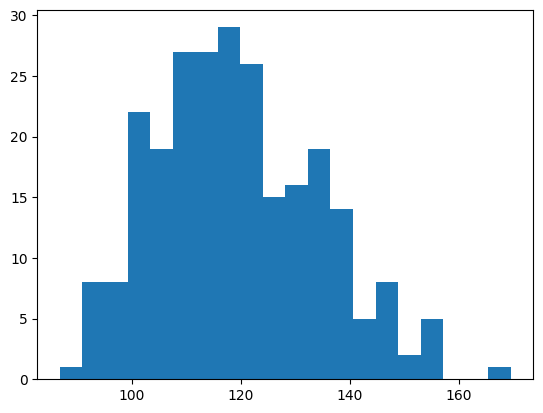

In [53]:
plt.hist(df_results["bp_mean"], bins=20)